In [67]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

In [68]:
def findFiles(path): return glob.glob(path)

print(findFiles('data_Names/data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data_Names/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

print(category_lines['French'][:5])


['data_Names/data/names\\Arabic.txt', 'data_Names/data/names\\Chinese.txt', 'data_Names/data/names\\Czech.txt', 'data_Names/data/names\\Dutch.txt', 'data_Names/data/names\\English.txt', 'data_Names/data/names\\French.txt', 'data_Names/data/names\\German.txt', 'data_Names/data/names\\Greek.txt', 'data_Names/data/names\\Irish.txt', 'data_Names/data/names\\Italian.txt', 'data_Names/data/names\\Japanese.txt', 'data_Names/data/names\\Korean.txt', 'data_Names/data/names\\Polish.txt', 'data_Names/data/names\\Portuguese.txt', 'data_Names/data/names\\Russian.txt', 'data_Names/data/names\\Scottish.txt', 'data_Names/data/names\\Spanish.txt', 'data_Names/data/names\\Vietnamese.txt']
Slusarski
['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']


In [69]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [70]:
import torch.nn as nn

# ------------ Creating the network ------------------
 
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

input = lineToTensor('Guez')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

# ---------- Praeparing Training ----------------

def categoryFromOutput(output): # Return the greatest likelihood out of the 18 possibilities
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) # position
    line_tensor = lineToTensor(line) # Encoding
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
    
    
    
    

tensor([[-2.9590, -2.8452, -2.9783, -2.7976, -2.8640, -2.9170, -2.8976, -2.8509,
         -2.8054, -2.8676, -2.8824, -3.0013, -2.8889, -2.8181, -2.9316, -2.8823,
         -2.9122, -2.9563]], grad_fn=<LogSoftmaxBackward>)
('Dutch', 3)
category = English / line = Umney
category = Dutch / line = Achthoven
category = Czech / line = Dolejsi
category = German / line = Schafer
category = Vietnamese / line = Luu
category = Czech / line = Vlasek
category = Polish / line = Kijek
category = German / line = Enns
category = Japanese / line = Egami
category = German / line = Groe


5000 5% (0m 9s) 2.9312 Mojjis / Greek ✗ (Czech)
10000 10% (0m 18s) 1.4577 Seah / Vietnamese ✗ (Chinese)
15000 15% (0m 28s) 2.3312 Layton / Scottish ✗ (English)
20000 20% (0m 37s) 2.4044 Dunlop / Scottish ✗ (English)
25000 25% (0m 46s) 1.8306 Theunissen / Dutch ✓
30000 30% (0m 55s) 0.7891 Nghiem / Vietnamese ✓
35000 35% (1m 4s) 3.0536 Warner / German ✗ (English)
40000 40% (1m 13s) 2.0591 Wieck / Czech ✗ (German)
45000 45% (1m 23s) 1.5127 Teoh / Vietnamese ✗ (Chinese)
50000 50% (1m 32s) 0.1464 Orsini / Italian ✓
55000 55% (1m 41s) 0.7149 Attia / Arabic ✓
60000 60% (1m 50s) 1.0690 Ghanem / Arabic ✓
65000 65% (1m 59s) 1.8817 Hughes / Scottish ✗ (English)
70000 70% (2m 8s) 0.3249 Scotti / Italian ✓
75000 75% (2m 17s) 0.1965 O'Leary / Irish ✓
80000 80% (2m 27s) 0.2212 Rinaldi / Italian ✓
85000 85% (2m 35s) 2.5648 Fuentes / Portuguese ✗ (Spanish)
90000 90% (2m 45s) 0.9112 Ho / Vietnamese ✗ (Korean)
95000 95% (2m 54s) 1.5771 Sze  / Polish ✗ (Chinese)
100000 100% (3m 3s) 1.4971 Mai / Chinese ✗ 

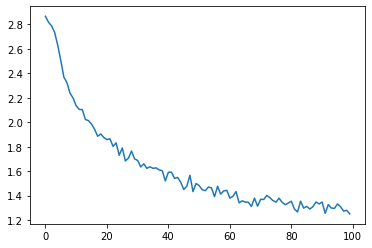

In [71]:
#  ----------- Training the network -----------------

criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()



import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
# ----------- Plotting Results -------------------

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


# ---------- Evalusation the results ------------

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()